In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import spacy
import re
import warnings

warnings.filterwarnings('ignore', message='Discarded redundant search for Synset')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt') 
nltk.download('stopwords')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('omw-1.4')
nlp = spacy.load("en_core_web_sm")

from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
Word2Vec_corpus = api.load('text8') 
Word2Vec_model = Word2Vec(Word2Vec_corpus) 
glove_model = api.load("glove-twitter-25") 

from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk.wsd import lesk
from nltk.chunk import ne_chunk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.utils import deaccent
from sklearn.decomposition import LatentDirichletAllocation as LDA
from spacy.matcher import Matcher

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/leon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/leon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/leon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/leon/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/leon/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/leon/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/leon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloadin

In [2]:
files = ['Data/Customer_review_data/Apex AD2600 Progressive-scan DVD player.txt',
         'Data/Customer_review_data/Canon G3.txt',
         'Data/Customer_review_data/Creative Labs Nomad Jukebox Zen Xtra 40GB.txt',
         'Data/Customer_review_data/Nikon coolpix 4300.txt',
         'Data/Customer_review_data/Nokia 6610.txt',
         'Data/CustomerReviews-3_domains/Computer.txt',
         'Data/CustomerReviews-3_domains/Router.txt',
         'Data/CustomerReviews-3_domains/Speaker.txt',
         'Data/Reviews-9-products/Canon PowerShot SD500.txt',
         'Data/Reviews-9-products/Canon S100.txt',
         'Data/Reviews-9-products/Diaper Champ.txt',
         'Data/Reviews-9-products/Hitachi router.txt',
         'Data/Reviews-9-products/ipod.txt',
         'Data/Reviews-9-products/Linksys Router.txt',
         'Data/Reviews-9-products/MicroMP3.txt',
         'Data/Reviews-9-products/Nokia 6600.txt',
         'Data/Reviews-9-products/norton.txt']

In [3]:
def pre_process_review(reviews):

    processed_reviews = []
    title_switch = False
    title = ''

    for review in reviews:
        if review.startswith('[t]'):
            title = review[3:]
            title_switch = True
        elif title_switch:
            appended_review = review + title 
            processed_reviews.append(appended_review)
            title_switch = False
            title = ''
        else:
            processed_reviews.append(review)

    return processed_reviews



def preserve_compound_phrases(text):
    doc = nlp(text)
    processed_tokens = []
    
    for token in doc:
        if token.dep_ in ('compound', 'amod') and token.head.pos_ == 'NOUN':
            compound_phrase = token.text + "_" + token.head.text
            if compound_phrase not in processed_tokens:
                processed_tokens.append(compound_phrase)
        elif token.pos_ == 'NOUN' and any(child.dep_ == 'compound' for child in token.children):
            continue
        else:
            processed_tokens.append(token.text)
    
    return processed_tokens
    


def read_file(file_path):
    tagged_reviews = []
    
    with open(file_path, 'r') as file:
        text = file.read()
        reviews = text.strip().split('\n')

        if reviews[0] == '*' * 77:
            reviews = reviews[11:]

        reviews = pre_process_review(reviews)
        
        for review in reviews:
            parts = review.split('##')
            
            if len(parts) > 1:
                tags = parts[0].strip().split(',')
                content = parts[1].strip() 
            else:
                tags = []
                content = parts
                
            tagged_reviews.append({'Tags': tags, 'Review': content})

        df = pd.DataFrame(tagged_reviews)
        df.attrs['title'] = file_path.split('/')[-1]

        return df
        

df = read_file(files[3])

In [68]:
df['Tokenised_Review'] = df['Review'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x) 
df['Tokenised_Review'] = df['Tokenised_Review'].apply(lambda review: preserve_compound_phrases(review))
df['Filtered_Review'] = df['Tokenised_Review'].apply(lambda tokens: [token.lower() for token in tokens if ("_" in token) or (token.isalpha() and token.lower() not in stop_words)])
df['Filtered_Review_String'] = df['Filtered_Review'].apply(lambda tokens: ' '.join(tokens))
df['Lemmatised_Review_String'] = df['Filtered_Review_String'].apply(lambda review_string: " ".join([token.lemma_ for token in nlp(review_string)]))
df['Lemmatised_Tokenised_Filtered_Review'] = df['Filtered_Review_String'].apply(lambda review: word_tokenize(review))
df['Stemmed_Review'] = df['Lemmatised_Tokenised_Filtered_Review'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])
df['Stemmed_Review_String'] = df['Stemmed_Review'].apply(lambda tokens: ' '.join(tokens))
# df.head(50)

In [5]:
all_words = [word for review in df['Filtered_Review'] for word in review]
freq_dist = FreqDist(all_words)

def display_freq_dist(freq_dist):
    top_items = sorted(freq_dist.items(), key=lambda x: x[1], reverse=True)[:20]
    words, frequencies = zip(*top_items)
    plt.figure(figsize=(6, 3))  
    plt.bar(words, frequencies, color='skyblue')  
    plt.xlabel('Words') 
    plt.ylabel('Frequency') 
    plt.title('Top Words Frequency Distribution')  
    plt.xticks(rotation=45) 
    plt.show()

# display_freq_dist(freq_dist)

Cluster 0: ['camera', 'buy', 'use', 'get', 'nikon', 'easy', 'one', 'feature', 'battery', 'well']
Cluster 1: ['picture', 'take', 'pic', 'mb', 'come', 'camera', 'quality', 'set', 'produce', 'use']




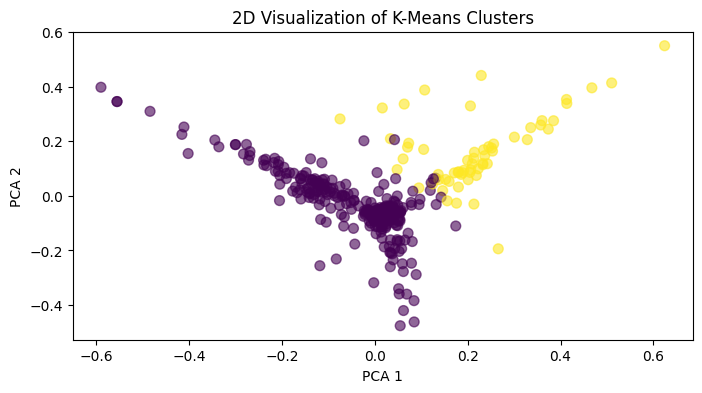

In [36]:
def k_means(string_list):

    num_clusters = 2

    tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), max_df=0.85, min_df=2)
    tfidf_matrix = tfidf_vectorizer.fit_transform(string_list)
    
    km = KMeans(n_clusters=num_clusters, n_init=10)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()
    
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    terms = tfidf_vectorizer.get_feature_names_out()
    
    for i in range(num_clusters):
        top_terms = [terms[ind] for ind in order_centroids[i, :10]]  # Get top 10 terms for each cluster
        print(f"Cluster {i}: {top_terms}")
    
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(tfidf_matrix.toarray())
    
    # Get the cluster labels for each data point
    cluster_labels = km.labels_
    
    plt.figure(figsize=(8, 4))  # Set figure size
    
    # Scatter plot of the reduced data, colored by cluster labels
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.6)
    
    # Adding labels for axes
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    
    # Title of the plot
    plt.title('2D Visualization of K-Means Clusters')
    
    # Display the plot
    print('\n')
    plt.show()


# k_means(df['Filtered_Review_String'])
k_means(df['Lemmatised_Review_String'])
# k_means(df['Stemmed_Review_String'])

In [37]:
def POS_Noun_Tagging(string_list):
    
    reviews = string_list.tolist()
    features = []
    
    for review in reviews:
        tokens = word_tokenize(review)
        tagged = pos_tag(tokens)
        # Extracts nouns from POS tagged text as nouns likely features names
        features.extend([word.lower() for word, tag in tagged if tag in ['NN', 'NNS', 'NNP', 'NNPS']])
    
    feature_counts = Counter(features)
    common_features = feature_counts.most_common(15)
    print(common_features)

    return common_features



# POS_Noun_Tagging(df['Filtered_Review_String'])
# print('\n')
pos_noun_tagging_list = POS_Noun_Tagging(df['Lemmatised_Review_String'])
# print('\n')
# POS_Noun_Tagging(df['Stemmed_Review_String'])

[('camera', 124), ('picture', 48), ('use', 35), ('battery', 19), ('feature', 15), ('time', 15), ('pic', 12), ('coolpix', 11), ('problem', 11), ('digital_camera', 11), ('mode', 10), ('size', 10), ('zoom', 10), ('purchase', 9), ('image', 9)]


In [38]:
def Noun_Phrase_Chuncking(string_list):

    all_noun_phrases = []
    
    for review in string_list:
        doc = nlp(review)
        noun_phrases = [chunk.text.lower() for chunk in doc.noun_chunks]
        all_noun_phrases.extend(noun_phrases)
    
    # Count the occurrences of each noun phrase
    from collections import Counter
    phrase_counts = Counter(all_noun_phrases).most_common(15)
    
    # Display most common noun phrases
    common_phrases = phrase_counts
    print(common_phrases)
    
    return common_phrases
    


# Noun_Phrase_Chuncking(df['Filtered_Review_String'])
# print('\n')
noun_chucked_phrases = Noun_Phrase_Chuncking(df['Lemmatised_Review_String'])
# print('\n')
# Noun_Phrase_Chuncking(df['Stemmed_Review_String'])

[('camera', 24), ('picture', 16), ('coolpix', 6), ('everything', 4), ('pic', 4), ('manual', 4), ('something', 3), ('picture_quality', 3), ('problem', 3), ('quality picture', 3), ('easy use', 2), ('lcd', 2), ('photography', 2), ('more_pow power', 2), ('reason', 2)]


In [39]:
# --------------------- Concrete noun filter 1 ---------------------

def is_concrete_noun(word):
    """Enhanced check if a noun is concrete based on its hypernyms and usage context."""
    concrete_clues = {'object', 'artifact', 'instrumentality', 'container', 'device'}
    synsets = wn.synsets(word, pos=wn.NOUN)
    for synset in synsets:
        for hyper in synset.closure(lambda s: s.hypernyms()):
            if concrete_clues.intersection(set(hyper.lemma_names())):
                return True
    return False


def context_based_filter(nouns):
    """Filter nouns based on enhanced concrete checks and contextual usage."""
    filtered_features = []
    for noun in nouns:
        if is_concrete_noun(noun):
            filtered_features.append(noun)
    return filtered_features




# --------------------- Concrete noun filter 2 ---------------------

# Define a list of concrete domains (as WordNet synsets)
concrete_domains = [
    wn.synset('artifact.n.01'),  # Artifacts, objects made by humans
    wn.synset('device.n.01'),    # Devices, tools or instruments
    wn.synset('instrumentality.n.03'),  # Instrumentalities, means of achieving an end
    # Add more domains as necessary
]

def is_related_to_concrete_domain(word):
    """
    Check if a word is semantically related to predefined concrete domains.
    """
    synsets = wn.synsets(word, pos=wn.NOUN)
    for synset in synsets:
        for domain in concrete_domains:
            if domain in synset.closure(lambda s: s.hypernyms()):
                return True
    return False


def filter_nouns_semantically(nouns):
    """
    Filter a list of nouns, keeping only those related to concrete domains.
    """
    return [noun for noun in nouns if is_related_to_concrete_domain(noun)]




noun_list = ['camera', 'digital_camera', 'use', 'buy', 'canon', 'take', 'need', 'review', 'great_camera', 'best_camera', 'get', 'use', \
             'picture', 'take', 'canon', 'well', 'one', 'photo', 'time', 'flash']
             

filtered_nouns = filter_nouns_semantically(noun_list)
print(filtered_nouns)
print('\n')
context_based_filter_nouns = context_based_filter(noun_list)
print(context_based_filter_nouns)

['camera', 'digital_camera', 'review', 'picture', 'well', 'photo', 'flash']


['camera', 'digital_camera', 'canon', 'review', 'picture', 'canon', 'well', 'photo', 'flash']


In [52]:
def similarity_filter(word_tuple_list):
    
    # Define a threshold for filtering; this is arbitrary and might need adjustment
    similarity_threshold = 0.1
    
    # Extract just the words for similarity comparison
    words = [word for word, _ in word_tuple_list]
    
    # Calculate average similarities and filter
    filtered_words = []
    for word in words:
        try:
            # Calculate similarity using Word2Vec
            w2v_similarity = Word2Vec_model.wv.similarity(words[0], word)
            # Get the top N similar words using GloVe and convert to a dictionary for easier access
            glove_similar_words = dict(glove_model.most_similar(words[0], topn=10))
            # Get the similarity score for the current word from the GloVe model
            glove_similarity = glove_similar_words.get(word, 0)  # Default to 0 if word is not found
            # Average the similarities
            avg_similarity = (w2v_similarity + glove_similarity) / 2
            # Filter based on the threshold
            if avg_similarity >= similarity_threshold:
                filtered_words.append(word)
        except KeyError:
            # Word not in vocabulary
            # print(f"Word '{word}' not found in one of the model's vocabulary.")
            pass
    
    print(filtered_words)
    return filtered_words


similar_noun_chuncked_list = similarity_filter(noun_chucked_phrases)
# print('\n')
similar_pos_noun_list = similarity_filter(pos_noun_tagging_list)

['camera', 'picture', 'pic', 'manual', 'lcd', 'photography']
['camera', 'picture', 'battery', 'feature', 'pic', 'mode', 'zoom', 'image']


In [65]:
def further_similar_filter(noun_list):
    
    main_word = 'picture'
    word = 'pic'
    
    w2v_similarity = Word2Vec_model.wv.similarity(main_word, word)
    glove_similar_words = dict(glove_model.most_similar(main_word, topn=10))
    glove_similarity = glove_similar_words.get(word, 0) 
    
    items_to_remove = []
    for word in noun_list:
        glove_similar_words = dict(glove_model.most_similar(main_word, topn=10))
        glove_similarity = glove_similar_words.get(word, 0) 
        if glove_similarity > 0:
            items_to_remove.append(word)
    
    filtered_list = [item for item in noun_list if item not in items_to_remove]
    print(filtered_list)
    return filtered_list


# feature_list_chuncked = further_similar_filter(similar_noun_chuncked_list)
feature_list_pos_noun = further_similar_filter(similar_pos_noun_list)

['camera', 'picture', 'battery', 'feature', 'mode', 'zoom', 'image']


In [124]:
def create_product_features_dict(product_info):
    # Extract the product title
    product_title = product_info[0]

    # Extract the features
    product_features = product_info[1:]

    # Create the dictionary with the desired structure
    product_dict = {
        product_title: {
            feature: {"positive": 0, "negative": 0} for feature in product_features
        }
    }

    return product_dict


product_dict = create_product_features_dict(feature_list_pos_noun)
display(product_dict)

{'camera': {'picture': {'positive': 0, 'negative': 0},
  'battery': {'positive': 0, 'negative': 0},
  'feature': {'positive': 0, 'negative': 0},
  'mode': {'positive': 0, 'negative': 0},
  'zoom': {'positive': 0, 'negative': 0},
  'image': {'positive': 0, 'negative': 0}}}

In [127]:
feature_df = pd.DataFrame()
feature_list = feature_list_pos_noun[1:]

for idx, review in df.iterrows():
    tokenised_review = review['Filtered_Review']
    if any(item in tokenised_review for item in feature_list):
        review_df = review.to_frame().transpose()
        feature_df = pd.concat([review_df, feature_df],  axis=0)
        
feature_df = feature_df.reset_index(drop=True)

feature_df

,Tags,Review,Tokenised_Review,Filtered_Review,Filtered_Review_String,Lemmatised_Review_String,Lemmatised_Tokenised_Filtered_Review,Stemmed_Review,Stemmed_Review_String
0,"[closeup mode[+2], battery[+2]]","the same 4mp chip from the 4500 camera , plus ...","[the, same_chip, 4mp_chip, chip, from, the, 45...","[same_chip, 4mp_chip, chip, camera, plus, 3x_z...",same_chip 4mp_chip chip camera plus 3x_zoom ab...,same_chip 4mp_chip chip camera plus 3x_zoom ab...,"[same_chip, 4mp_chip, chip, camera, plus, 3x_z...","[same_chip, 4mp_chip, chip, camera, plu, 3x_zo...",same_chip 4mp_chip chip camera plu 3x_zoom abi...
1,"[auto mode[+2], scene mode[+2], manual mode[+2]]",the auto-mode is good enough for most shots bu...,"[the, auto_mode, -, is, good, enough, for, mos...","[auto_mode, good, enough, most_shots, shots, a...",auto_mode good enough most_shots shots also bo...,auto_mode good enough most_shot shot also boas...,"[auto_mode, good, enough, most_shots, shots, a...","[auto_mod, good, enough, most_shot, shot, also...",auto_mod good enough most_shot shot also boast...
2,[],4 an ac adapter for powering the camera while ...,"[4, an, ac_adapter, adapter, for, powering, th...","[ac_adapter, adapter, powering, camera, batter...",ac_adapter adapter powering camera battery inc...,ac_adapt adapter power camera battery include ...,"[ac_adapter, adapter, powering, camera, batter...","[ac_adapt, adapt, power, camera, batteri, incl...",ac_adapt adapt power camera batteri includ alt...
3,[],3 battery has to be removed to recharge .,"[3, battery, has, to, be, removed, to, recharg...","[battery, removed, recharge]",battery removed recharge,battery remove recharge,"[battery, removed, recharge]","[batteri, remov, recharg]",batteri remov recharg
4,[],you just have to use the lcd viewfinder to see...,"[you, just, have, to, use, the, lcd, viewfinde...","[use, lcd, viewfinder, see, whole_picture, pic...",use lcd viewfinder see whole_picture picture,use lcd viewfinder see whole_picture picture,"[use, lcd, viewfinder, see, whole_picture, pic...","[use, lcd, viewfind, see, whole_pictur, pictur]",use lcd viewfind see whole_pictur pictur
5,[],"this does n't affect the picture , of course .","[this, does, n't, affect, the, picture, ,, of,...","[affect, picture, course]",affect picture course,affect picture course,"[affect, picture, course]","[affect, pictur, cours]",affect pictur cours
6,[optical zoom[+2]],9 3x built-in optical zoom is a lot for this p...,"[9, 3x, built_zoom, -, in, optical_zoom, zoom,...","[built_zoom, optical_zoom, zoom, lot, price_ra...",built_zoom optical_zoom zoom lot price_range,built_zoom optical_zoom zoom lot price_range,"[built_zoom, optical_zoom, zoom, lot, price_ra...","[built_zoom, optical_zoom, zoom, lot, price_rang]",built_zoom optical_zoom zoom lot price_rang
7,[battery[+2]],the battery recharges ral fast and the recharg...,"[the, battery, recharges, ral, fast, and, the,...","[battery, recharges, ral, fast, recharger_thin...",battery recharges ral fast recharger_thingy co...,battery recharge ral fast recharger_thingy com...,"[battery, recharges, ral, fast, recharger_thin...","[batteri, recharg, ral, fast, recharger_thingi...",batteri recharg ral fast recharger_thingi come...
8,[],my room is so dark and when i tried taking pic...,"[my, room, is, so, dark, and, when, i, tried, ...","[room, dark, tried, taking, pics, old_camera, ...",room dark tried taking pics old_camera camera ...,room dark try take pic old_camera camera come ...,"[room, dark, tried, taking, pics, old_camera, ...","[room, dark, tri, take, pic, old_camera, camer...",room dark tri take pic old_camera camera came ...
9,[picture quality[+3]],after a lengthy and extensive journey for a fe...,"[after, a, lengthy_journey, and, extensive, jo...","[lengthy_journey, extensive, journey, feature,...",lengthy_journey extensive journey feature load...,lengthy_journey extensive journey feature load...,"[lengthy_journey, extensive, journey, feature,...","[lengthy_journey, extens, j

In [85]:
def LDA_Model(tokenised_reviews):
    
    # Create a dictionary representation of the documents
    dictionary = corpora.Dictionary(tokenised_reviews)
    
    # Convert dictionary to a bag of words corpus
    corpus = [dictionary.doc2bow(text) for text in tokenised_reviews]
    
    # Number of topics
    num_topics = 5
    
    # Generate LDA model
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, update_every=1, passes=10, alpha='auto')
    
    # Print the topics
    topics = lda_model.print_topics(num_words=5)
    for topic in topics:
        print(topic)
        

# LDA_Model(df['Stemmed_Review'])
# print('\n')
# LDA_Model(df['Filtered_Review'])
# print('\n')
# LDA_Model(df['Lemmatised_Tokenised_Filtered_Review'])

In [424]:
def LDA_Model_2(string_reviews):
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(string_reviews)
    
    num_topics = 5
    lda = LDA(n_components=num_topics)
    lda.fit_transform(tfidf_matrix)
    
    # Explore the topics
    terms = tfidf_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda.components_):
        print(f"Topic #{topic_idx+1}:")
        print(" ".join([terms[i] for i in topic.argsort()[:-10 - 1:-1]]))
        print('\n')

# LDA_Model_2(df['Lemmatised_Review_String'])

In [425]:
"""
Getting the sentiment of multiword phrases using SentiWordNet (SWN) through the NLTK library requires a more nuanced approach compared to single words because SentiWordNet does not directly provide sentiment scores for phrases. Instead, you can average the sentiment scores of individual words in the phrase, adjust the methodology to consider the phrase's context, or use compound term lookup techniques where applicable. Here’s an approach to approximate sentiment for multiword phrases:

### Step 1: Handle Compound Terms

Some compound terms might be recognized by SentiWordNet if connected by underscores (e.g., "well_known"). Before splitting the phrase into individual words, check if the compound term has an entry in SentiWordNet.

### Step 2: Average Sentiment Scores of Individual Words

For phrases not recognized as compound terms, calculate the average sentiment scores of the individual words. Consideration of part-of-speech tags can enhance accuracy, but for simplicity, this example ignores POS tags.

### Note:

- This method assumes equal weighting of words in calculating the average sentiment, which might not reflect the actual sentiment conveyed by the phrase.
- Handling negations and intensifiers (e.g., "not" in "not good", "very" in "very good") requires more sophisticated logic, as they can significantly alter the sentiment.
- Advanced models designed for sentiment analysis at the sentence or document level (like BERT-based models) may provide more accurate sentiment assessments for phrases and sentences by considering the broader context.

This approach gives a basic approximation but is limited by the nuances of natural language. For more accurate sentiment analysis on phrases or sentences, consider using pre-trained sentiment analysis models or services.
"""


def get_word_sentiment(word):
    synsets = list(swn.senti_synsets(word))
    if synsets:
        return synsets[0].pos_score(), synsets[0].neg_score()
    else:
        return 0, 0


def get_phrase_sentiment(phrase):
    # Try the phrase directly (useful for compound terms recognized by SWN)
    pos_score, neg_score = get_word_sentiment(phrase.replace(" ", "_"))
    if pos_score or neg_score:
        return pos_score, neg_score
    
    # Split the phrase into individual words and average their sentiment scores
    words = phrase.split()
    total_pos, total_neg = 0, 0
    for word in words:
        pos, neg = get_word_sentiment(word)
        total_pos += pos
        total_neg += neg
    avg_pos = total_pos / len(words) if words else 0
    avg_neg = total_neg / len(words) if words else 0
    
    return avg_pos, avg_neg

# Example usage
phrase = 'not very well known'
pos_score, neg_score = get_phrase_sentiment(phrase)
print(f"Phrase: '{phrase}', Pos score: {pos_score}, Neg score: {neg_score}")



"""
This version attempts to address negations directly before a word and could be extended to consider intensifiers (like "very") by further
modifying the sentiment scores. For even more nuanced sentiment analysis, exploring deep learning models trained specifically for sentiment 
analysis is recommended.
"""


def penn_to_wn(tag):
    """Converts Penn Treebank tags to WordNet tags."""
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

def get_word_sentiment(word, tag):
    wn_tag = penn_to_wn(tag)
    if wn_tag:
        synsets = list(swn.senti_synsets(word, wn_tag))
        if synsets:
            return synsets[0].pos_score(), synsets[0].neg_score()
    return 0, 0

def adjust_scores_for_negation_and_intensifiers(scores, words, i):
    """Adjusts sentiment scores based on negations and intensifiers around the i-th word."""
    if i > 0 and words[i-1].lower() in ["not", "no"]:
        return -scores[0], -scores[1]  # Inverting the sentiment
    # Further adjustments for intensifiers (like "very") can be added here
    return scores

def get_phrase_sentiment(phrase):
    words = word_tokenize(phrase)
    tagged = pos_tag(words)
    total_pos, total_neg = 0, 0
    
    for i, (word, tag) in enumerate(tagged):
        scores = get_word_sentiment(word, tag)
        scores = adjust_scores_for_negation_and_intensifiers(scores, words, i)
        total_pos += scores[0]
        total_neg += scores[1]
    
    avg_pos = total_pos / len(words) if words else 0
    avg_neg = total_neg / len(words) if words else 0
    
    return avg_pos, avg_neg

# Example usage
phrase = 'not very well known'
pos_score, neg_score = get_phrase_sentiment(phrase)
print(f"Phrase: '{phrase}', Pos score: {pos_score}, Neg score: {neg_score}")

Phrase: 'not very well known', Pos score: 0.125, Neg score: 0.15625
Phrase: 'not very well known', Pos score: 0.03125, Neg score: 0.09375


In [412]:
def disambiguate_word_sense(sentence, word):
    # Use Lesk algorithm for WSD
    sense = lesk(nltk.word_tokenize(sentence), word)
    if not sense:
        return None
    
    # Get sentiment scores
    senti_synset = swn.senti_synset(sense.name())
    return {
        'word': word,
        'synset_name': sense.name(),
        'definition': sense.definition(),
        'examples': sense.examples(),
        'positivity_score': senti_synset.pos_score(),
        'negativity_score': senti_synset.neg_score(),
        'objectivity_score': senti_synset.obj_score()
    }


review = df.iloc[200]

for word in review['Filtered_Review']:
    disambiguated_sense = disambiguate_word_sense(review['Review'], word)
    # print(disambiguated_sense)
    # print('\n')

In [413]:
def preprocess_and_ner(tokens):
    
    tagged = pos_tag(tokens)
    named_entities = ne_chunk(tagged)
    return named_entities


tokenised_text = df['Filtered_Review'].iloc[106]
named_entities = preprocess_and_ner(tokenised_text)
# print(named_entities)

In [414]:
def tf_idf(reviews):
    # Initialize the TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer()
    
    # Transform the reviews into a TF-IDF matrix
    tfidf_matrix = tfidf_vectorizer.fit_transform(reviews)
    
    # Extract the feature names/terms from the TF-IDF Vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Calculate the average TF-IDF score for each term across all documents
    scores = tfidf_matrix.mean(axis=0)
    term_scores = {feature_names[col]: scores[0, col] for col in range(scores.shape[1])}
    
    # Sort the terms by their average TF-IDF score in descending order
    sorted_term_scores = sorted(term_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Optionally: Display the top 10 terms with the highest average TF-IDF scores
    print("Top 15 terms by average TF-IDF score:")
    for term, score in sorted_term_scores[:15]:
        print(f"Term: {term}, Score: {round(score, 4)}")
    
    # Calculate cosine similarity among the documents using the TF-IDF matrix
    cos_sim_matrix = cosine_similarity(tfidf_matrix)
    
    # return tfidf_matrix, feature_names, cos_sim_matrix

# tf_idf(df['Filtered_Review_String'])

In [415]:
matcher = Matcher(nlp.vocab)

# Define custom patterns
patterns = [
    [{"POS": "ADJ"}, {"POS": "NOUN", "OP": "+"}],  # Adjective followed by one or more nouns
    [{"POS": "NOUN", "OP": "+"}, {"LOWER": "mode"}]  # One or more nouns followed by "mode"
]
matcher.add("CUSTOM_PATTERNS", patterns)


def POS_Chuck_Parser_Matcher(review):
    doc = nlp(review)
    matches = matcher(doc)

    extracted_phrases = []
    for match_id, start, end in matches:
        span = doc[start:end]
        extracted_phrases.append(span.text)

    print(extracted_phrases)

In [416]:
def POS_Chuck_Parser(review):

    doc = nlp(review)
    
    # Initialize a list to hold our extracted phrases
    extracted_phrases = []
    
    # Iterate over tokens in the doc
    for token in doc:
        # Look for an adverb modifying an adjective and check the adjective doesn't have a noun child
        if token.pos_ == "ADV" and token.head.pos_ == "ADJ":
            is_adj_modified = False
            for child in token.head.children:
                if child.dep_ in ["attr", "dobj", "pobj"]:  # The adjective is modifying a noun
                    is_adj_modified = True
                    break
            if not is_adj_modified:
                # Capture the adverb-adjective pair "rather heavy"
                extracted_phrases.append(token.text + " " + token.head.text)
    
        # Look for an adjective modifying a noun and check if it's in a prepositional phrase
        if token.pos_ == "ADJ" and token.head.pos_ in ["NOUN", "PROPN"]:
            is_in_prep_phrase = False
            for ancestor in token.head.ancestors:
                if ancestor.dep_ == "prep":
                    is_in_prep_phrase = True
                    break
            if not is_in_prep_phrase:
                # Capture the adjective-noun pair "great camera"
                extracted_phrases.append(token.text + " " + token.head.text)

    print(extracted_phrases)

In [417]:
index = 24

print(df['Tags'].iloc[index])
print(df['Review'].iloc[index])
print('\n')

POS_Chuck_Parser(df['Review'].iloc[index])
POS_Chuck_Parser(df['Filtered_Review_String'].iloc[index])
POS_Chuck_Parser(df['Lemmatised_Review_String'].iloc[index])

print('\n')

POS_Chuck_Parser_Matcher(df['Review'].iloc[index])
POS_Chuck_Parser_Matcher(df['Filtered_Review_String'].iloc[index])
POS_Chuck_Parser_Matcher(df['Lemmatised_Review_String'].iloc[index])

['']
i bought coolpix 4300 two months after i had bought canon powershot s400 . not too excited


['too excited']
[]
[]


[]
[]
[]
